# Characteristics of Time Series

In [ ]:
# Load packages
using Distributions
using PyPlot
using RData
using StatsBase

matplotlib.rcParams["text.usetex"] = true;

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling RData [df47a6cb-8c03-5eed-afd8-b6050d6c41da]
└ @ Base loading.jl:1278


## Exercise 1.1

In [2]:
# Load data
EQ5 = load("../data/EQ5.rda")
EXP6 = load("../data/EXP6.rda");

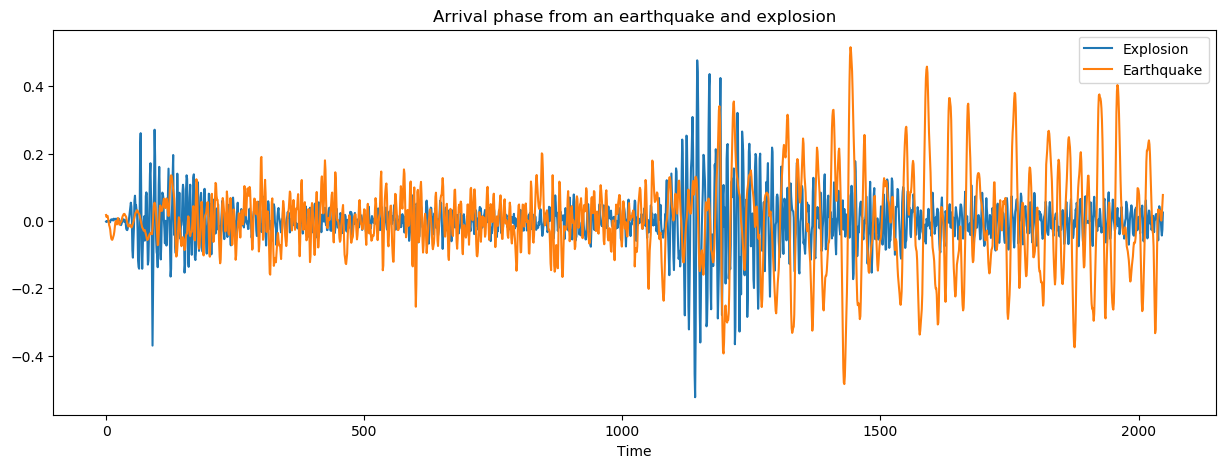

In [3]:
# Plot the data
figure(figsize=(15, 5))
plot(EXP6["EXP6"], label="Explosion")
plot(EQ5["EQ5"], label="Earthquake")
xlabel("Time")
legend()
title("Arrival phase from an earthquake and explosion")
show()

We observe that the earthquake follows the explosion. There should be a high correlation between the moment of the explosion and few moments later for the earthquake. Secondly, the intensity of the earthquake might depend on the intensity of the explosion.

## Exercise 1.2

Let's assume the following signal-plus-noise model:
$$x_t = s_t + w_t, \quad w_t \sim \mathcal{N}(0, 1)$$

* *Question (a)*

$x_t = s_t + w_t$, for $t = 1, \dots, 200$, where

$$s_t = \left\{
    \begin{array}{l l} 
        0, & t = 1, \dots, 100 \\ 
        10\exp\left(-\frac{(t - 100)}{20}\right)\cos(2\pi t / 4), & t = 101, \dots, 200
    \end{array}
  \right.$$

In [22]:
function signal_a(l)
    return [t < 101 ? 0 : 10 * exp(-(t - 100) / 20) * cos(2 * pi * t / 4) for t in l]
end

function signal_plus_noise_a(l)
    w = rand(Normal(), length(l))
    return signal_a(l) + w
end

signal_plus_noise_a (generic function with 1 method)

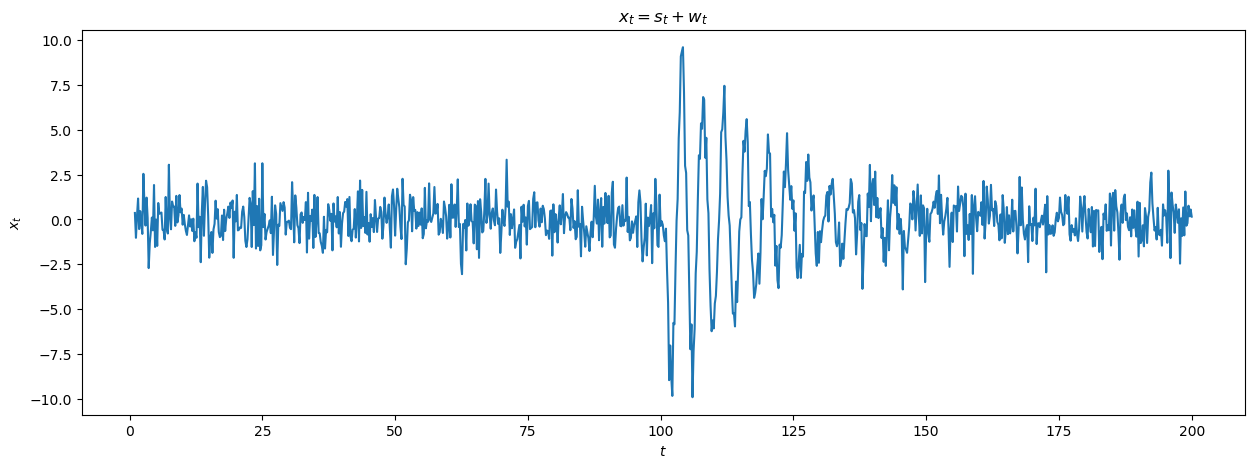

In [5]:
figure(figsize=(15, 5))
plot(1:0.2:200, signal_plus_noise_a(1:0.2:200))
xlabel(L"$t$")
ylabel(L"$x_t$")
title(L"x_t = s_t + w_t")
show()

* *Question (b)*

$x_t = s_t + w_t$, for $t = 1, \dots, 200$, where

$$s_t = \left\{
    \begin{array}{l l} 
        0, & t = 1, \dots, 100 \\ 
        10\exp\left(-\frac{(t - 100)}{200}\right)\cos(2\pi t / 4), & t = 101, \dots, 200
    \end{array}
  \right.$$

In [6]:
function signal_b(l)
    return [t < 101 ? 0 : 10 * exp(-(t - 100) / 200) * cos(2 * pi * t / 4) for t in l]
end

function signal_plus_noise_b(l)
    w = rand(Normal(), length(l))
    return signal_b(l) + w
end

signal_plus_noise_b (generic function with 1 method)

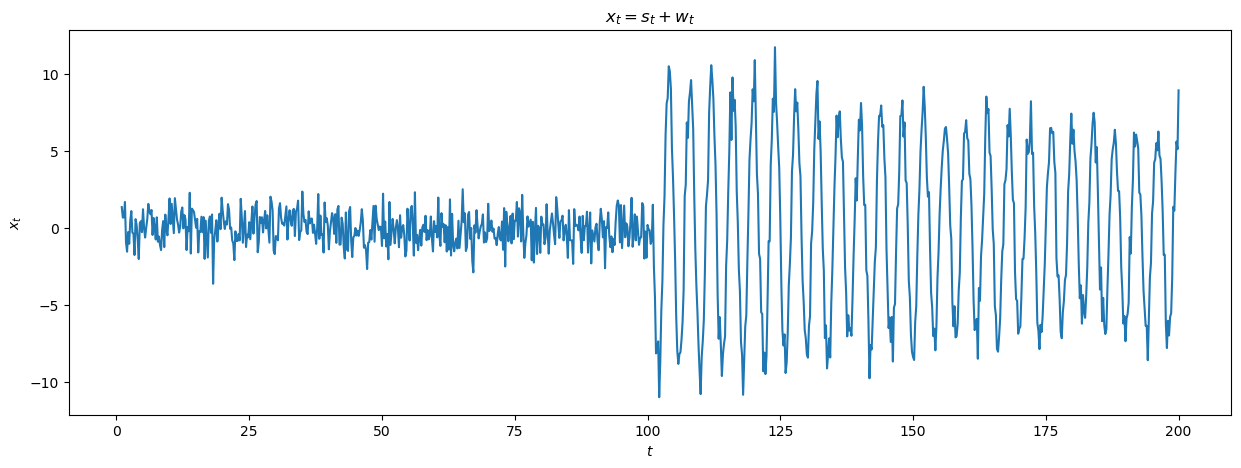

In [7]:
figure(figsize=(15, 5))
plot(1:0.2:200, signal_plus_noise_b(1:0.2:200))
xlabel(L"$t$")
ylabel(L"$x_t$")
title(L"x_t = s_t + w_t")
show()

* *Question (c)*

The serie (a) appears to be quite close to the explosion serie and the serie (b) appears to be quite close to the earthquake serie. Let's plot the signal modulators (a) $\exp(-t / 20)$ and (b) $\exp(-t / 200)$, for $t = 1, \dots, 100$.

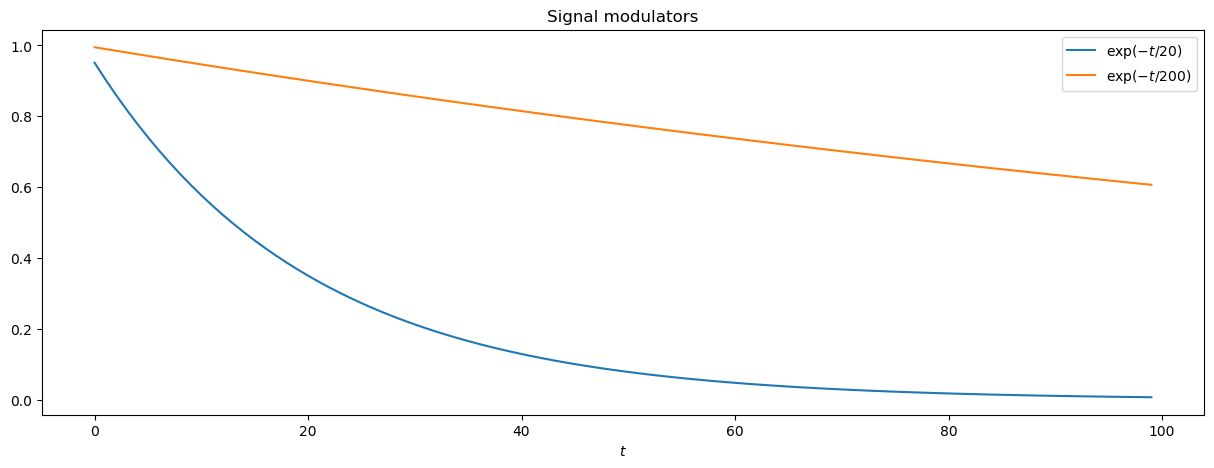

In [8]:
figure(figsize=(15, 5))
plot([exp(-t / 20) for t in 1:100], label=L"\exp(-t / 20)")
plot([exp(-t / 200) for t in 1:100], label=L"\exp(-t / 200)")
xlabel(L"$t$")
title("Signal modulators")
legend()
show()

The decreasing of the intensity of the first signal modulators is way larger than the second one.

## Exercise 1.3

* *Question (a)*

Consider the autoregression model:
$$x_t = -0.9x_{t-2} + w_t, \quad w_t \sim \mathcal{N}(0, 1).$$

First, we will define a recursive filter function and a convolution filter function (based on the [C function](https://github.com/SurajGupta/r-source/blob/master/src/library/stats/src/filter.c) of the **R** package stats).

In [5]:
function filter_recursive(x, filter)
    nx = length(x)
    nf = length(filter)
    
    out = vcat(x, Array{Float64}(undef, nf))
    for i in 1:nx
        Σ = x[i]
        for j in 1:nf
            tmp = out[i + nf - j]
            Σ += filter[j] * tmp
        end
        out[i + nf] = Σ
    end
    return out[(nf + 1):end]
end

function filter_convolution(x, filter, sides)
    nx = length(x)
    nf = length(filter)
    
    nshift = (sides == 1) ? 0 : div(nf, 2)
    
    out = Array{Float64}(undef, nx)
    for i in 1:nx
        z = 0
        if (i + nshift - nf < 0) || (i + nshift > nx)
            out[i] = NaN
            continue
        end
        for j in (max(1, i + nshift - nx)):(min(nf, i + nshift - 1))
            tmp = x[i + nshift - j]
            z += filter[j] * tmp
        end
        out[i] = z
    end
    return out
end

filter_convolution (generic function with 1 method)

In [10]:
w = rand(Normal(), 500)
x = filter_recursive(w, [0, -0.9])
x_filter = filter_convolution(x, [0.25, 0.25, 0.25, 0.25], 1);

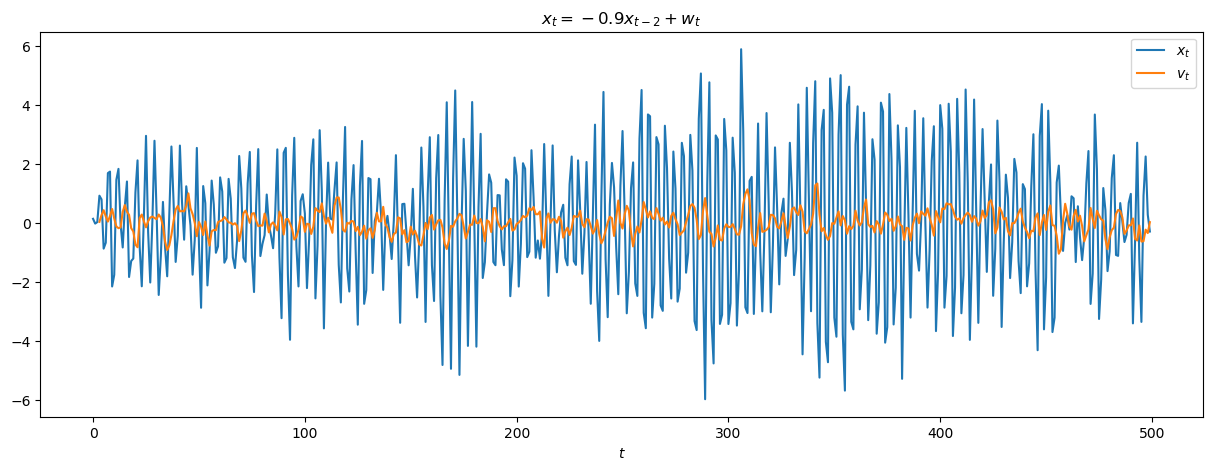

In [11]:
# Plot the time series
figure(figsize=(15, 5))
plot(x, label=L"x_t")
plot(x_filter, label=L"v_t")
xlabel(L"$t$")
title(L"x_t = -0.9x_{t-2} + w_t")
legend()
show()

The behavior of $x_t$ is very erratic, even if we might see some patterns within. The moving average filter completely change that behavior and smooth the serie such that no patterns are discernable.

* *Question (b)*

Consider the model:
$$x_t = \cos(2\pi t / 4).$$

In [12]:
x = [cos(2 * pi * t / 4) for t in 1:0.2:100]
x_filter = filter_convolution(x, [0.25, 0.25, 0.25, 0.25], 1);

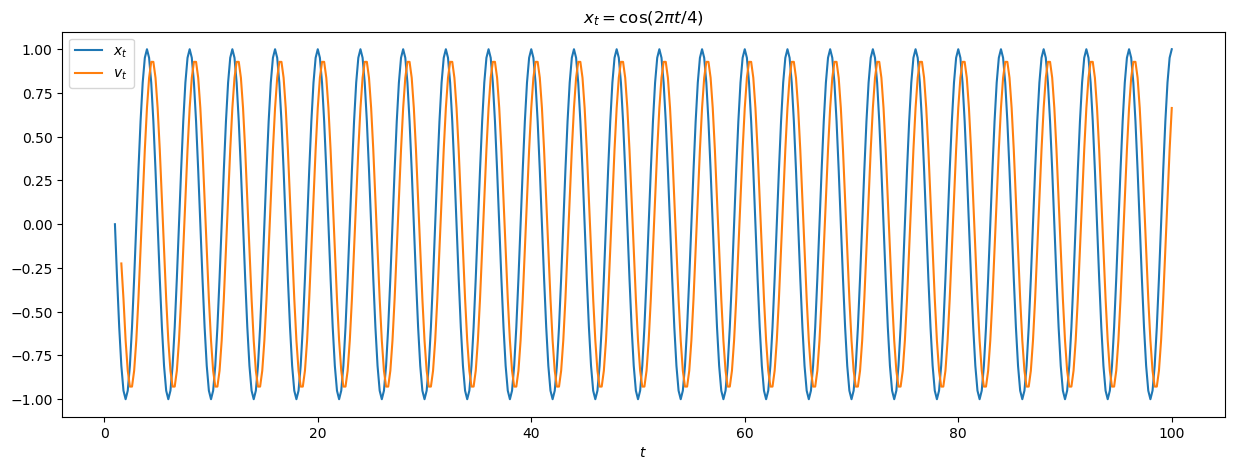

In [13]:
# Plot the time series
figure(figsize=(15, 5))
plot(1:0.2:100, x, label=L"x_t")
plot(1:0.2:100, x_filter, label=L"v_t")
xlabel(L"$t$")
title(L"x_t = \cos(2\pi t / 4)")
legend()
show()

The moving average filter has the effect of shifting the signal in this case.

* *Question (c)*

Consider the model:
$$x_t = \cos(2\pi t / 4) + w_t, \quad w_t \sim \mathcal{N}(0, 1).$$

In [14]:
w = rand(Normal(), 496)
x = [cos(2 * pi * t / 4) for t in 1:0.2:100] + w
x_filter = filter_convolution(x, [0.25, 0.25, 0.25, 0.25], 1);

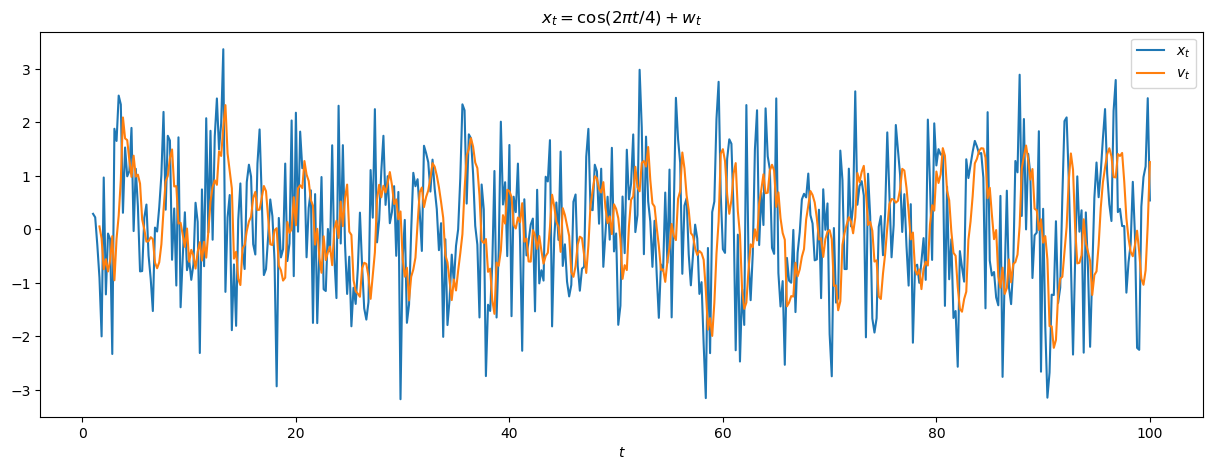

In [15]:
# Plot the time series
figure(figsize=(15, 5))
plot(1:0.2:100, x, label=L"x_t")
plot(1:0.2:100, x_filter, label=L"v_t")
xlabel(L"$t$")
title(L"x_t = \cos(2\pi t / 4) + w_t")
legend()
show()

Here, the moving average filter removes a bit the noise in the signal to recover the underlying "true" form of the signal.

* *Question (d)*

The filtering behaves differently for the different examples. For the first one, as the signal is basically just noise, the filtering will remove this component and so, return something close to 0. For the second one, there is no noise is the signal, the filtering insert a time lag in the signal. And for the last one, the filtering performs both the denoising and the shift of the signal. To obtain just a denoising, the filtering should be centered around the value. Something like,
$$v_t = (x_{t+2} + x_{t+1} + x_{t-1} + x_{t-2}) / 4.$$

## Exercise 1.4

Show that the autocovariance function can be written as
$$\gamma(s, t) = \mathbb{E}(x_sx_t) - \mu_s\mu_t, \quad\text{where}\quad \mathbb{E}(x_t) = \mu_t.$$

\begin{align}
\gamma(s, t) &= \mathbb{E}\left((x_s - \mu_s)(x_t - \mu_t\right) \\
             &= \mathbb{E}\left(x_sx_t - \mu_sx_t - x_s\mu_t + \mu_s\mu_t\right) \\
             &= \mathbb{E}(x_sx_t) - \mu_s\mathbb{E}(x_t) - \mu_t\mathbb{E}(x_s) + \mu_s\mu_t \\
             &= \mathbb{E}(x_sx_t) - \mu_s\mu_t
\end{align}

## Exercise 1.5

Recall the two series in the exercise 1.2:

* First serie:
$x_t = s_t + w_t$, for $t = 1, \dots, 200$, where

$$s_t = \left\{
    \begin{array}{l l} 
        0, & t = 1, \dots, 100 \\ 
        10\exp\left(-\frac{(t - 100)}{20}\right)\cos(2\pi t / 4), & t = 101, \dots, 200
    \end{array}
  \right.$$
  
* Second serie:
$x_t = s_t + w_t$, for $t = 1, \dots, 200$, where

$$s_t = \left\{
    \begin{array}{l l} 
        0, & t = 1, \dots, 100 \\ 
        10\exp\left(-\frac{(t - 100)}{200}\right)\cos(2\pi t / 4), & t = 101, \dots, 200
    \end{array}
  \right.$$
  
* *Question (a)*

We are in the case of *signal plus noise* model. So, in both serie, the mean functions will be $s(t)$.

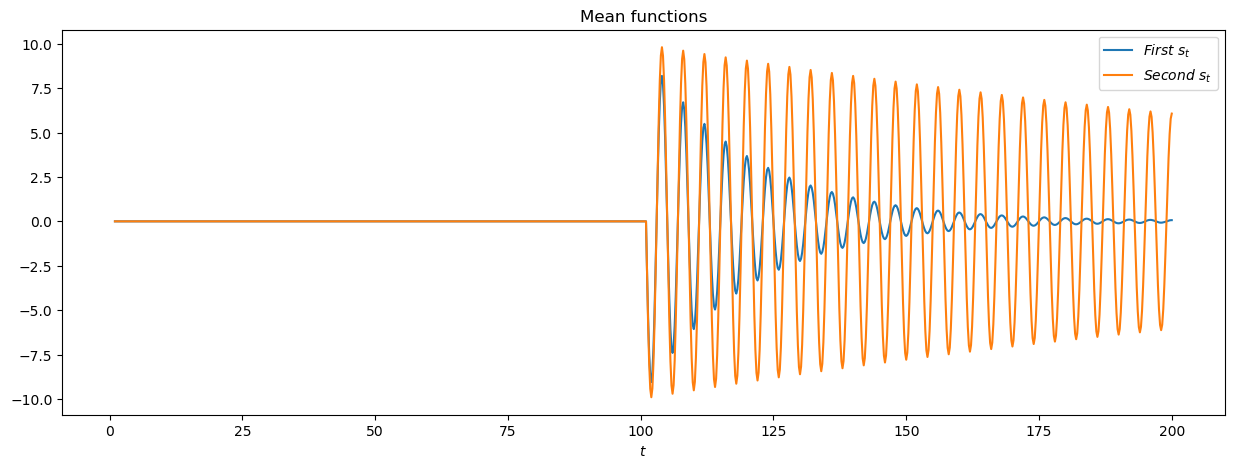

In [16]:
# Plot the mean functions
figure(figsize=(15, 5))
plot(1:0.2:200, signal_a(1:0.2:200), label=L"First~ s_t")
plot(1:0.2:200, signal_b(1:0.2:200), label=L"Second~ s_t")
xlabel(L"$t$")
title("Mean functions")
legend()
show()

* *Question (b)*

The autocovariance of the series will be the same, that is:
\begin{align}
\gamma(s,t) &= Cov(x_s, x_t) \\
            &= Cov(s_s + w_s, s_t + w_t) \\
            &= Cov(s_s, s_t) + Cov(s_s, w_t) + Cov(s_t, w_s) + Cov(w_s, w_t) \\
            &= Cov(w_s, w_t) \\
            &= \left\{
                    \begin{array}{r c l}
                        1 &if& s = t\\
                        0 &if& s \neq t \\
                    \end{array}
               \right.
\end{align}

## Exercise 1.6

Consider the time series
$$x_t = \beta_1 + \beta_2t + w_t,$$
where $\beta_1$ and $\beta_2$ are known constants and $w_t$ is a white noise process with variance $\sigma^2_w$.

* *Question (a)*

The serie $x_t$ is not (weakly) stationary because its mean function depends on time $t$:
$$\mu_x(t) = \beta_1 + \beta_2t.$$

* *Question (b)*

Define the process $y_t = x_t - x_{t - 1} = \beta_2 + w_t - w_{t - 1}$.

The mean function of the process $y_t$ is $\beta_2$ and, so, does not depend on time $t$.

The autocovariance is:
\begin{align}
\gamma(s, t) &= Cov(y_s, y_t) \\
             &= Cov(\beta_2 + w_s - w_{s-1}, \beta_2 + w_t - w_{t-1}) \\
             &= Cov(w_s, w_t) - Cov(w_s, w_{t-1}) - Cov(w_{s-1}, w_t) + Cov(w_{s-1}, w_{t-1}) \\
             &= \left\{
                    \begin{array}{r c l}
                        2\sigma_w^2 &if& s - t = 0\\
                        -\sigma_w^2 &if& \vert s - t \vert = 1\\
                    \end{array}
               \right.
\end{align}

So, the autocovariance only depends on the lag between $s$ and $t$ and not the absolute location of the points along the serie.

Finally, as the variance is finite, the serie is (weakly) stationary.

* *Question (c)*

The mean of the moving average is
\begin{align}
\mathbb{E}(v_t) &= \mathbb{E}\left(\frac{1}{2q + 1}\sum_{j=-q}^{q}x_{t-j}\right) \\
                &= \frac{1}{2q + 1}\sum_{j=-q}^{q}\mathbb{E}(x_{t-j}) \\
                &= \frac{1}{2q + 1}\sum_{j=-q}^{q}\mathbb{E}(\beta_1 + \beta_2(t-j) + w_{t-j}) \\
                &= \beta_1 + \beta_2t - \frac{\beta_2}{2q+1}\sum_{j=-q}^{q}j \\
                &= \beta_1 + \beta_2t
\end{align}

The autocovariance function is, for all $h$,
\begin{align}
\gamma(h) &= Cov(v_t, v_{t + h}) \\
          &= Cov\left(\frac{1}{2q + 1}\sum_{j=-q}^{q}x_{t-j}, \frac{1}{2q + 1}\sum_{i=-q}^{q}x_{t-i+h}\right) \\
          &= \left(\frac{1}{2q + 1}\right)^2 Cov\left(\sum_{j=-q}^{q}w_{t-j},\sum_{i=-q}^{q}w_{t-i+h}\right) \\
          &= \left(\frac{\sigma}{2q + 1}\right)^2 \sum_{i, j = -q}^q \mathbb{1}(i - j = h) \\
          &= \left\{
                    \begin{array}{r c l}
                        \left(\frac{\sigma}{2q + 1}\right)^2  &if& \lvert h \rvert \leq 2q\\
                        0 &if& \lvert h \rvert > 2q\\
                    \end{array}
               \right.
\end{align}

## Exercise 1.7

Consider the moving average process 
$$x_t = w_{t-1} + 2w_t + w_{t+1},$$
where $w_t$ are independent with zero means and variacne $\sigma_w^2$.

The autocovariance function is
\begin{align}
\gamma(h) &= Cov(x_t, x_{t+h}) \\
          &= Cov(w_{t-1} + 2w_t - w_{t+1}, w_{t-1+h} + 2w_{t+h} - w_{t+1+h}) \\
          &= \left\{
               \begin{array}{r c l}
                 6\sigma_w^2 &if& h = 0\\
                 4\sigma_w^2 &if& \vert h \vert = 1\\
                 \sigma_w^2 &if& \vert h \vert = 2\\
                 0 &if& \vert h \vert > 2\\
               \end{array}
             \right.
\end{align}

The autocorrelation function is
\begin{align}
\rho(h) &= \gamma(h) / \gamma(0) \\
        &= \left\{
             \begin{array}{r c l}
               1 &if& h = 0\\
               2/3 &if& \vert h \vert = 1\\
               1/6 &if& \vert h \vert = 2\\
               0 &if& \vert h \vert > 2\\
             \end{array}
           \right.
\end{align}

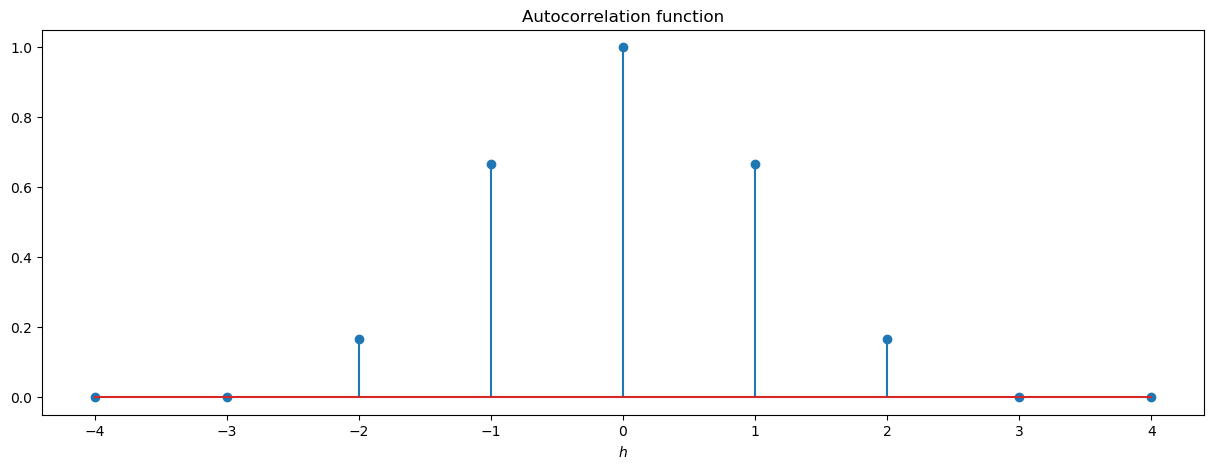

In [20]:
# Plot the ACF
figure(figsize=(15, 5))
stem(-4:4, [0, 0, 1/6, 2/3, 1, 2/3, 1/6, 0, 0], use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

## Exercise 1.8

Consider the random walk with drift model
$$x_t = \delta + x_{t-1} + w_t, \quad t = 1, 2, \dots$$
with $x_0 = 0$, where $w_t$ is white noise with variance $\sigma_w^2$.

* *Question (a)*

Proof by induction:
- $x_1 = \delta + x_0 + w_1 = \delta + w_1$
- Assume that the relation is true for $x_t$, we have
$$x_{t + 1} = \delta + x_t + w_{t+1} = \delta + \left(\delta t + \sum_{k=1}^t w_k\right) + w_{k+1} = \delta(t+1) + \sum_{k=1}^{t+1} w_k.$$

* *Question (b)*

The mean function of $x_t$ is
$$\mathbb{E}(x_t) = \mathbb{E}\left(\delta t + \sum_{k=1}^{t}w_{k}\right) = \delta t + \sum_{k=1}^{t}\mathbb{E}(w_{k}) = \delta t$$

The autocovariance function of $x_t$ is
$$\gamma(s, t) = Cov(x_s, x_t) = Cov\left(\sum_{k=1}^s w_k, \sum_{j=1}^t w_j\right) = \sum_{k=1}^s \sum_{j=1}^t Cov(w_k, w_j) = \min(s, t)\sigma_w^2.$$

* *Question (c)*

$x_t$ is not stationary because its mean function depends on $t$ and its autocovariance function depends on the particular time values $s$ and $t$, and not on the time separation $\lvert s - t \rvert$.

* *Question (d)*

$$\rho(t-1, t) = \frac{\gamma(t-1, t)}{\sqrt{\gamma(t-1, t-1)\gamma(t, t)}} = \frac{(t-1)\sigma^2}{\sqrt{(t-1)\sigma^2(t)\sigma^2}} = \sqrt{\frac{t-1}{t}} = \sqrt{1 - \frac{1}{t}} \xrightarrow[t \rightarrow \infty]{} 1$$

It means that, when $t$ goes to infinity, $x_t$ and $x_{t-1}$ are almost exactly the same thing. Intuitively, if we plot $x_t$ against $x_{t-1}$, we should obtain a straight line that pass through $(0, 0)$.

* *Question (e)*

Consider the serie: $y_t = x_t - x_{t-1} = \delta + w_t$.

Then, the serie is stationary because: $\mathbb{E}(y_t) = \delta$ and $\gamma(s, t) = \sigma^2\mathbb{1}(s = t)$.

## Exercise 1.9

Consider the serie
$$x_t = U_1\sin(2\pi\omega_0t) + U_2\cos(2\pi\omega_0t)$$
where $U_1$ and $U_2$ are independent random variables with zero means and $\mathbb{E}(U_1^2) = \mathbb{E}(U_2^2) = \sigma^2$.

The mean function is
$$\mathbb{E}(x_t) = \mathbb{E}(U_1\sin(2\pi\omega_0t) + U_2\cos(2\pi\omega_0t)) = \sin(2\pi\omega_0t)\mathbb{E}(U_1) + \cos(2\pi\omega_0t)\mathbb{E}(U_2) = 0.$$

The autocovariance function is
\begin{align}
\gamma(h) &= Cov(x_t, x_{t+h}) \\
          &= Cov(U_1\sin(2\pi\omega_0t) + U_2\cos(2\pi\omega_0t), U_1\sin(2\pi\omega_0(t+h)) + U_2\cos(2\pi\omega_0(t+h)))\\
          &= \sin(2\pi\omega_0t)\sin(2\pi\omega_0(t+h))Cov(U_1, U_1) + \cos(2\pi\omega_0t)\cos(2\pi\omega_0(t+h))Cov(U_2, U_2)\\
          &= \sigma^2\cos(2\pi\omega_0t - 2\pi\omega_0(t+h))\\
          &= \sigma^2\cos(2\pi\omega_0h)
\end{align}

Thus, the serie is weakly stationary with the given autocovariance function.

## Exercise 1.10

Suppose we would like to predict a single stationary series $x_t$ with zero mean and autocorrelation function $gamma(h)$ at some time in the future $t + l$, for $l > 0$.

* *Question (a)*

Compute the derivative of $MSE(A)$ with respect to $A$:
$$\frac{\partial MSE(A)}{\partial A} = -2\mathbb{E}(x_tx_{t+l}) + 2A\mathbb{E}(x_t^2).$$

By setting the derivative to $0$:
$$\frac{\partial MSE(A)}{\partial A} = 0 \Longleftrightarrow A = \frac{\mathbb{E}(x_tx_{t+l})}{\mathbb{E}(x_t^2)} = \frac{Cov(x_t, x_{t+l})}{Var(x_t)} = \frac{\gamma(l)}{\gamma(0)} = \rho(l).$$

* *Question (b)*

$MSE(\rho(l)) = \mathbb{E}(x_{t+l}^2) - 2\rho(l)\mathbb{E}(x_tx_{t+l}) + \rho(l)^2\mathbb{E}(x_t^2) = \gamma(0)\left[1 - \rho(l)^2\right]$

* *Question (c)*

Assume $x_{t+l} = Ax_t$.

Then, \begin{align}
MSE(\rho(l)) = 0 &\Longleftrightarrow& 1 - \rho(l)^2 = 0 \\
                 &\Longleftrightarrow& \lvert \rho(l) \rvert = 1 \\
                 &\Longleftrightarrow& \left\{
                                         \begin{array}{r c l}
                                               \rho(l) = 1 &if& A > 0\\
                                               \rho(l) = -1 &if& A < 1\\
                                         \end{array}
                                       \right.
\end{align}

## Exercise 1.11

Consider the process
$$x_t = \mu + \sum_{j = -\infty}^{\infty} \phi_j\omega_{t-j}, \quad \sum_{j=\infty}^{\infty}\lvert \phi_j \rvert < +\infty$$
where $\omega_t \sim \mathcal{N}(0, \sigma^2)$.

* *Question (a)*

The autocovariance function is, for $h \leq 0$,
\begin{align}
\gamma(h) &= Cov(x_{t+h}, x_t) \\
          &= Cov\left(\sum_{j = -\infty}^{\infty} \phi_j\omega_{t-j+h}, \sum_{k = -\infty}^{\infty} \phi_k\omega_{t-k}\right) \\
          &= \sum_{j = -\infty}^{\infty} \sum_{k = -\infty}^{\infty} \phi_j\phi_kCov(\omega_{t-j+h}, \omega_{t-k})\\
          &= \sigma^2\sum_{j = -\infty}^{\infty} \phi_{k+h}\phi_k
\end{align}

And by symmetry, we have $\gamma(h) = \gamma(-h)$.

* *Question (b)*

Define $x_t^q = \mu + \sum_{j = -q}^{q} \phi_j\omega_{t-j}$. In order to prove that $x_t$ exists as a limit in mean square, we would prove that $x_t^q \longrightarrow x_t$. We have to show that $\mathbb{E}\lvert x_t^p - x_t^q \rvert^2 \longrightarrow 0, p > q > 0$.

\begin{align}
\mathbb{E}\lvert x_t^p - x_t^q \rvert^2 
    &= \mathbb{E}\left\lvert \sum_{j = -p}^{p} \phi_j\omega_{t-j} - \sum_{j = -q}^{q} \phi_j\omega_{t-j} \right\rvert^2 \\
    &= \mathbb{E}\left\lvert \sum_{q \leq \lvert j \rvert \leq p} \phi_j\omega_{t-j} \right\rvert^2 \\
    &= \sum_{q \leq \lvert j \rvert \leq p}\sum_{q \leq \lvert j \rvert \leq p}\phi_j\phi_k\mathbb{E}(\omega_{t-j}\omega_{t-k})\\
    &\leq \sum_{q \leq \lvert j \rvert \leq p}\sum_{q \leq \lvert j \rvert \leq p}\lvert\phi_j\rvert\lvert\phi_k\rvert\lvert\mathbb{E}(\omega_{t-j}\omega_{t-k})\rvert\\
    &\leq \sum_{q \leq \lvert j \rvert \leq p}\sum_{q \leq \lvert j \rvert \leq p}\lvert\phi_j\rvert\lvert\phi_k\rvert\mathbb{E}(\omega_{t-j}^2)^{1/2}\mathbb{E}(\omega_{t-k}^2)^{1/2}, \text{(Cauchy-Schwarz)}\\
    &\leq \sum_{q \leq \lvert j \rvert \leq p}\sum_{q \leq \lvert j \rvert \leq p}\lvert\phi_j\rvert\lvert\phi_k\rvert(\sigma^2 + \mu^2)^{1/2}(\sigma^2 + \mu^2)^{1/2}\\
    &= (\sigma^2 + \mu^2)\left(\sum_{q \leq \lvert j \rvert \leq p}\lvert\phi_j\rvert\right)^2 \longrightarrow 0
\end{align}

Let $S$ denotes the mean square limit of $x_t^q$, then using Fatou's lemma:
$$\mathbb{E}(\lvert S - x_t\rvert^2) = \mathbb{E}(\lim\inf \lvert S - x_t^q \rvert^2) \leq \lim\inf\mathbb{E}\lvert S - x_t^q\rvert^2 = 0.$$

And so, $x_t$ exists as a limit in mean square.

## Exercise 1.12

Consider two weakly stationary series $x_t$ and $y_t$. Showing that $\rho_{xy}(h) = \rho_{yx}(-h)$ is equivalent to show $\gamma_{xy}(h) = \gamma_{yx}(-h)$. Then,
$$\gamma_{xy}(h) = Cov(x_{t+h}, y_t) = Cov(x_u, y_{u-h}) = Cov(y_{u-h}, x_u) = \gamma_{yx}(-h).$$
The main part of the proof is done by substitution: $u = t + h$.

## Exercise 1.13

Consider the two series:
$$x_t = w_t \quad\text{and}\quad y_t = w_t - \theta w_{t-1} + u_t,$$
where $w_t$ and $u_t$ are independent white noise series with variance $\sigma_w^2$ and $\sigma_u^2$, respectively, and $\theta$ is an unspecified constant.

* *Question (a)*

\begin{align*}
\gamma_y(h) &= Cov(y_{t+h}, y_t) \\
            &= Cov(w_{t+h} - \theta w_{t-1+h} + u_{t+h}, w_t - \theta w_{t-1} + u_t) \\
            &= \left\{
                \begin{array}{c l l}
                    (1 + \theta^2)\sigma_w^2 + \sigma_u^2 &\text{if}& h = 0\\
                    -\theta\sigma_w^2 &\text{if}& |h| = 1 \\
                    0 &\text{else}&
                \end{array}
               \right.
\end{align*}

So,
$$\rho_y(h) = \left\{
                \begin{array}{c l l}
                    1 &\text{if}& h = 0\\
                    -\frac{\theta\sigma_w^2}{(1 + \theta^2)\sigma_w^2 + \sigma_u^2} &\text{if}& |h| = 1 \\
                    0 &\text{else}&
                \end{array}
               \right.$$
               
* *Question (b)*

We have that
$$\rho_{xy}(h) = \frac{\gamma_{xy}(h)}{\sqrt{\gamma_x(0)\gamma_y(0)}}, \quad \gamma_x(0) = \sigma_w^2, \quad \gamma_y(0) = (1 + \theta^2)\sigma_w^2 + \sigma_u^2$$
and
$$\gamma_{xy}(h) = Cov(x_{t+h}, y_t) = Cov(w_{t+h}, w_t - \theta w_{t-1} + u_t) = 
    \left\{
        \begin{array}{c l l}
            \sigma_w^2 &\text{if}& h = 0\\
            -\theta\sigma_w^2 &\text{if}& h = -1 \\
            0 &\text{else}&
        \end{array}
    \right.$$
 
* *Question (c)*

$x_t$ and $y_t$ are jointly stationary because $\rho_{xy}(h)$ is a function only of lag $h$.

## Exercise 1.14

Let $x_t$ be a stationary normal process with mean $\mu_x$ and autocovariance function $\gamma(h)$. Define the nonlinear time series $y_t = \exp(x_t)$.

* *Question (a)*

The serie $y_t$ is defined as the moment generating function of $x_t$ evaluated at $1$, $\mathbb{E}(y_t) = M_x(1)$.

$$\mathbb{E}(y_t) = \mathbb{E}(\exp(x_t)) = \exp(\mu + \gamma(0)/2).$$

* *Question (b)*

The sum of the two normal random variables $x_{t+h} + x_t$ is a normal random variable. Thus,
$$x_{t+h} + x_t \sim \mathcal{N}(2\mu_x, \gamma(h,h) + \gamma(0) + 2\gamma(h)).$$

\begin{align*}
Cov(y_{t+h}, y_t) &= \mathbb{E}\left((y_{t+h} - \mathbb{E}(y_{t+h}))(y_{t} - \mathbb{E}(y_t))\right) \\
                  &= \mathbb{E}(y_{t+h}y_t) - \mathbb{E}(y_{t+h})\mathbb{E}(y_t) \\
                  &= \mathbb{E}(\exp(x_{t+h} + x_t)) - \exp(\mu_x + \gamma(0)/2)^2 \\
                  &= \exp(2\mu_x + (\gamma(h,h) + \gamma(0) + 2\gamma(h)/2) - \exp(\mu_x + \gamma(0)/2)^2 \\
                  &= \exp(2\mu_x)\left(\exp\left(\frac{1}{2}(\gamma(h,h) + \gamma(0) + 2\gamma(h))\right) - \exp(\gamma(0))\right)
\end{align*}

## Exercise 1.15

Let $w_t$ be a normal white process, and consider the series
$$x_t = w_tw_{t-1}.$$

* Mean

$$\mathbb{E}(x_t) = \mathbb{E}(w_tw_{t-1}) = \mathbb{E}(w_t)\mathbb{E}(w_{t-1}) = 0$$

* Autocovariance

$$Cov(x_t{t+h}, x_t) = Cov(w_{t+h}w_{t+h-1}, w_tw_{t-1}) = \mathbb{E}(w_{t+h}w_{t+h-1}w_tw_{t-1}) = 
    \left\{
     \begin{array}{c l l}
      \sigma_w^4 &\text{if}& h = 0\\
      0 &\text{else}&
     \end{array}
    \right.$$

The serie $x_t$ is stationary because the mean function is constant and the autocovariance function only depends on the time lag $h$.

## Exercise 1.16

Consider the series $x_t = \sin(2\pi Ut)$, where $U$ has a uniform distribution on the interval $(0,1)$.

* *Question (a)*

\begin{align*}
\mathbb{E}(x_t) &= \mathbb{E}(\sin(2\pi Ut)) \\
                &= \int_0^1 \sin(2\pi ut)du \\
                &= \frac{1}{2\pi t}\left(1 - \cos(2\pi t)\right)
\end{align*}

As $t = 1, 2, \dots$, $\cos(2\pi t) = 1$, and thus, $\mathbb{E}(x_t) = 0$.

If $h \neq 0$, then
\begin{align*}
\gamma(h) &= Cov(x_{t+h}, x_t) \\
          &= Cov(\sin(2\pi U(t+h)), \sin(2\pi Ut)) \\
          &= \mathbb{E}(\sin(2\pi U(t+h))\sin(2\pi Ut)) \\
          &= \int_0^1 \sin(2\pi u(t+h))\sin(2\pi ut)du \\
          &= \frac{1}{2}\int_0^1 \left(\cos(2\pi uh) + \cos(2\pi u(2t+h))\right)du \\
          &= \frac{1}{2}\left(\frac{\sin(2\pi h)}{2\pi h} + \frac{\sin(2\pi (h+2t))}{2\pi (h + 2t)}\right) \\
          &= 0
\end{align*}

If $h = 0$, then
\begin{align*}
\gamma(0) &= Cov(x_t, x_t) \\
          &= \mathbb{E}(\sin^2(2\pi Ut)) \\
          &= \int_0^1 \sin(2\pi ut)^2du \\
          &= \frac{1}{2} - \frac{\sin(4\pi t)}{8\pi t} \\
          &= \frac{1}{2}, \quad\text{for}~ t = 1, 2, \dots
\end{align*}

Thus, the serie $x_t$ is weakly stationary.

* *Question (b)*

We have:

$$\mathbb{P}(X_1 \leq c) = \mathbb{P}(\sin(2\pi U) \leq c) = \mathbb{P}\left(U \leq \frac{1}{2\pi}\sin^{-1}(c)\right) = \frac{1}{2\pi}\sin^{-1}(c)$$

and

$$\mathbb{P}(X_2 \leq c) = \mathbb{P}(\sin(4\pi U) \leq c) = \mathbb{P}\left(U \leq \frac{1}{4\pi}\sin^{-1}(c)\right) = \frac{1}{4\pi}\sin^{-1}(c)$$

Thus, $\mathbb{P}(X_1 \leq c) \neq \mathbb{P}(X_2 \leq c)$. Finally, the serie $x_t$ is not strictly stationary.

## Exercise 1.17

Suppose we have a linear process $x_t$ generated by
$$x_t = w_t - \theta w_{t-1}, \quad t = 0, 1, 2, \dots$$
where $\{w_t\}$ is independent and identically distributed with characteristic function $\phi_w(\cdot)$ and $\theta$ a fixed constant.

* *Question (a)*

\begin{align*}
\phi_{x_1, \dots, x_n}(\lambda_1, \dots, \lambda_n) &= \mathbb{E}(\exp(i\langle \lambda, x \rangle)) \\
    &= \mathbb{E}\left[\exp\left(i\sum_{j = 1}^n \lambda_jx_j\right)\right] \\
    &= \mathbb{E}\left[\exp\left(i\sum_{j = 1}^n \lambda_j(w_t - \theta w_{t-1})\right)\right] \\
    &= \mathbb{E}\left[\exp\left(i\sum_{j = 1}^n \lambda_jw_t\right)\right]\mathbb{E}\left[\exp\left(-i\sum_{j = 1}^n \lambda_j\theta w_{t-1}\right)\right] \\
    &= \prod_{i = 1}^n \phi_w(\lambda_i)\phi_w(-\theta\lambda_i)
\end{align*}

* *Question (b)*

The characteristic function of $x_1, \dots, x_n$ is independent of the time, because $\{w\}$ is independent and identically distributed. Thus, $x_t$ is strictly stationary.

## Exercise 1.18

Let $x_t$ be a linear process of the form:
$$x_t = \mu + \sum_{j = -\infty}^{+\infty} \phi_jw_{t-j}, \quad \sum_{j = -\infty}^{+\infty}\lvert \phi_j \rvert < +\infty,$$
where $\{w_t\}$ is a white noise process.

\begin{align*}
\sum_{h = -\infty}^{+\infty}\lvert \gamma(h) \rvert &= \sum_{h = -\infty}^{+\infty}\left\lvert \sigma_w^2  \sum_{j = -\infty}^{+\infty} \phi_{j+h}\phi_j\right\rvert \\
&\leq \sigma_w^2\sum_{j = -\infty}^{+\infty}\sum_{h = -\infty}^{+\infty}\left\lvert \phi_{j+h}\right\rvert\left\lvert\phi_j \right\rvert \\
&\leq \sigma_w^2\sum_{j = -\infty}^{+\infty}\left\lvert\phi_j \right\rvert\sum_{h = -\infty}^{+\infty}\left\lvert \phi_{j+h}\right\rvert \\
&\leq +\infty
\end{align*}

## Exercise 1.19

Suppose $x_t = \mu + w_t + \theta w_{t-1}$, where $w_t \sim \mathcal{WN}(0, \sigma_w^2)$.

* *Question (a)*

$$\mathbb{E}(x_t) = \mu + \mathbb{E}(w_t) + \theta\mathbb{E}(w_{t-1}) = \mu$$

* *Question (b)*

\begin{align*}
\gamma_x(h) &= Cov(x_t, x_{t+h}) \\
            &= Cov(\mu + w_t + \theta w_{t-1}, \mu + w_{t+h} + \theta w_{t+h-1}) \\
            &= Cov(w_t, w_{t+h}) + \theta Cov(w_t, w_{t+h-1}) + \theta Cov(w_{t-1}, w_{t+h}) + \theta^2Cov(w_{t-1}, w_{t+h-1}) \\
            &= \left\{
                 \begin{array}{c l l}
                      (1 + \theta^2)\sigma_w^2 &\text{if}& h = 0\\
                      \theta \sigma_w^2 &\text{if}& \lvert h \rvert = 1 \\
                      0 &\text{else}
                 \end{array}
                \right.
\end{align*}

* *Question (c)*

For all values of $\theta \in \mathbb{R}$, $\mathbb{E}(x_t) = \mu$ is independent of $t$ and $\gamma_x(h)$ depends only on $h$. So, $x_t$ is stationary.

* *Question (d)*

\begin{align*}
Var(\bar{x}) &= \frac{1}{n}\sum_{h=-n}^n \left(1 - \frac{\lvert h \rvert}{n}\right)\gamma_x(h) \\
             &= \frac{1}{n}\left(2\left(1 - \frac{1}{n}\right)\theta \sigma_w^2 + (1 + \theta^2)\sigma_w^2\right)\\
             &= \frac{\sigma_w^2}{n}\left(2\left(1 - \frac{1}{n}\right)\theta + (1 + \theta^2)\right) \\
\end{align*}

   - If $\theta = 1$, $Var(\bar{x}) = \frac{\sigma_w^2}{n}\left(4 - \frac{2}{n}\right)$.
   - If $\theta = 0$, $Var(\bar{x}) = \frac{\sigma_w^2}{n}$.
   - If $\theta = -1$, $Var(\bar{x}) = \frac{2\sigma_w^2}{n^2}$.
   
* *Question (e)*

The standard error of the estimate of the mean is the square root of $Var(\bar{x})$.

   - If $\theta = 1$, $Var(\bar{x}) \approx \frac{4\sigma_w^2}{n} = \mathcal{o}(1)$.
   - If $\theta = 0$, $Var(\bar{x}) = \frac{\sigma_w^2}{n} = \mathcal{o}(1)$.
   - If $\theta = -1$, $Var(\bar{x}) \approx 0$.

## Exercise 1.20

* *Question (a)*

In [44]:
w = rand(Normal(), 500);

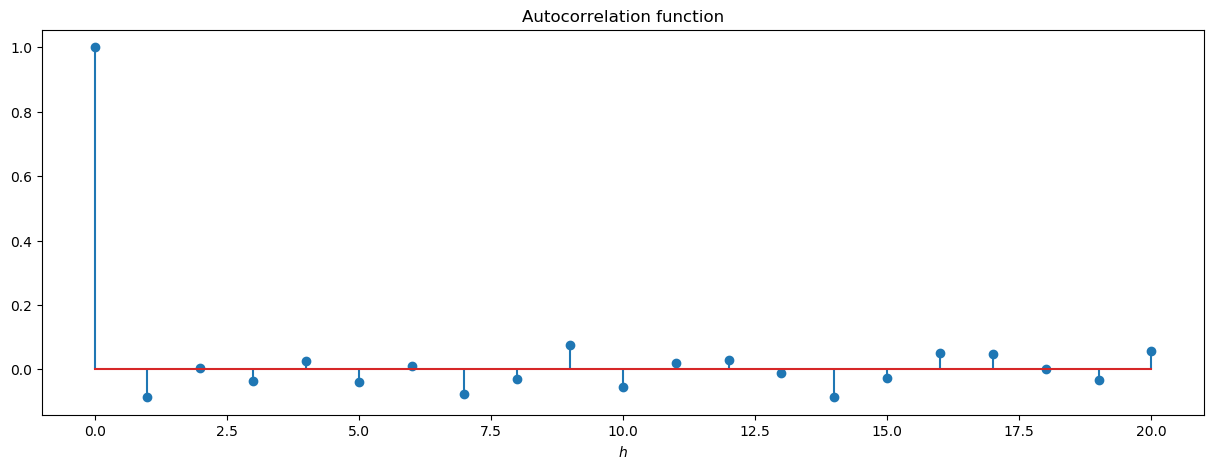

In [45]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:20, autocor(w, 0:20), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

* *Question (b)*

In [46]:
w = rand(Normal(), 50);

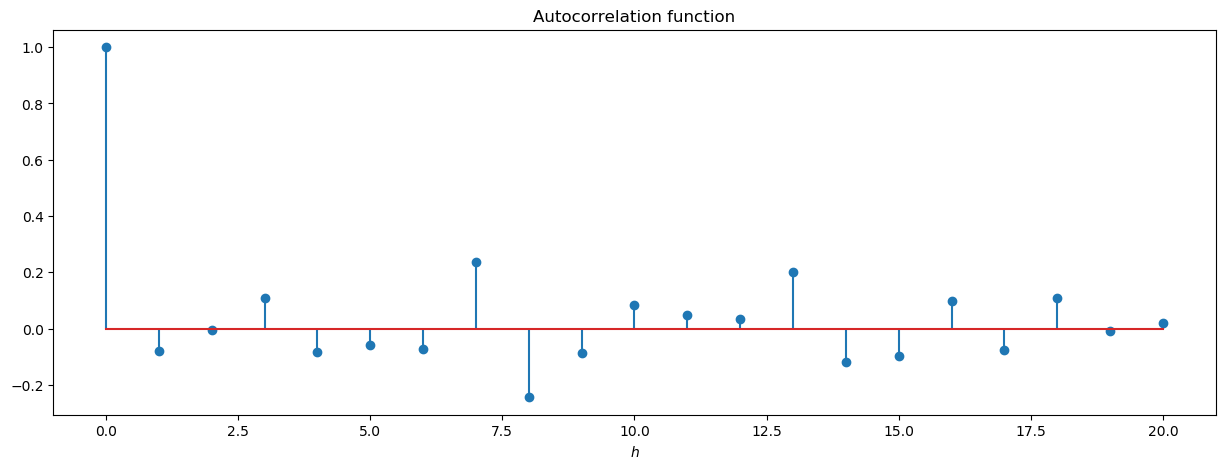

In [47]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:20, autocor(w, 0:20), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

The changing of $n$ affects a lot the results, when $n = 500$ the ACF has converged yet while it's not the case when $n = 50$.

## Exercise 1.21

* *Question (a)*

In [48]:
w = rand(Normal(), 550);
v = filter_convolution(w, [1/3, 1/3, 1/3], 2)[50:549];

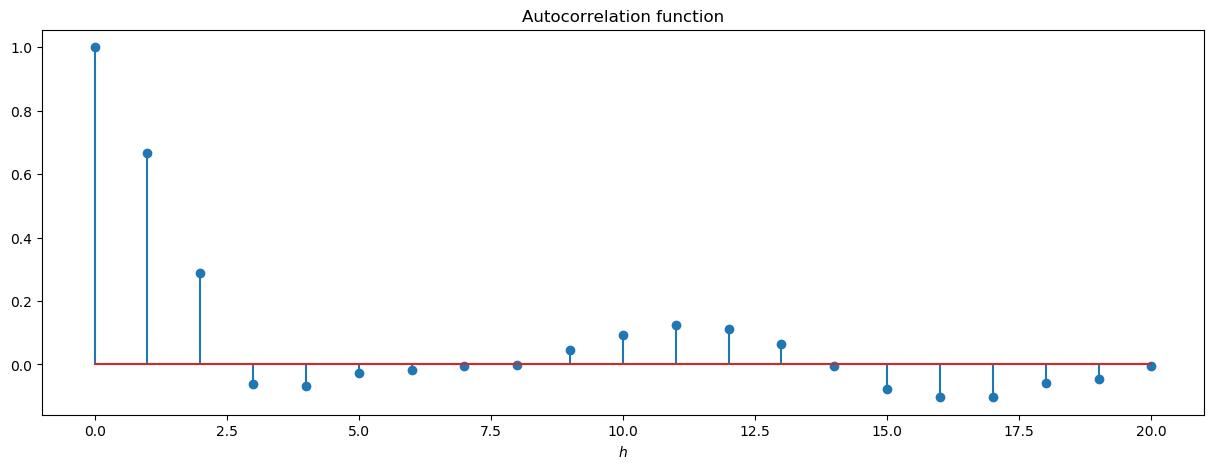

In [49]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:20, autocor(v, 0:20), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

In [50]:
w = rand(Normal(), 100);
v = filter_convolution(w, [1/3, 1/3, 1/3], 2)[50:99];

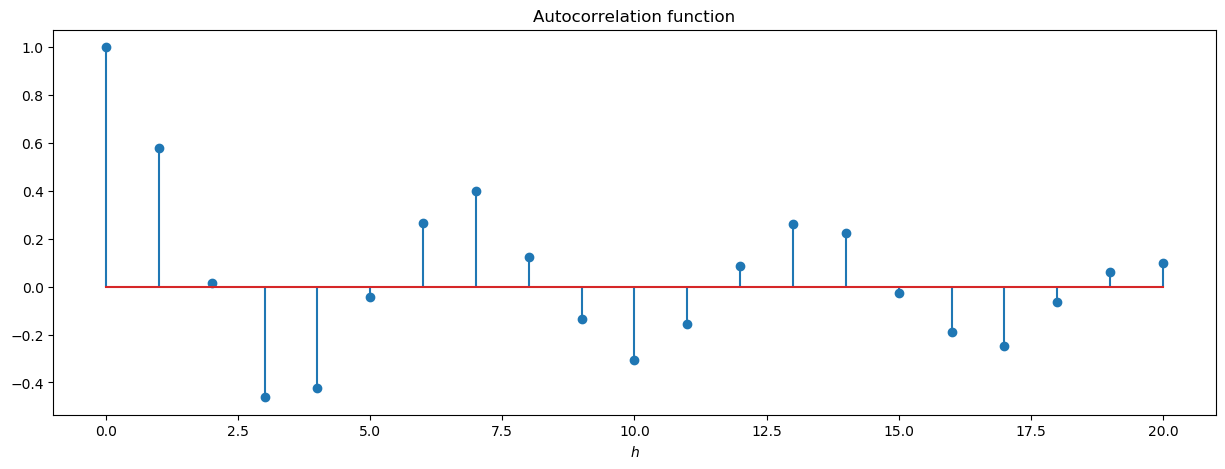

In [51]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:20, autocor(v, 0:20), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

The changing of $n$ affects a bit the results. When $n = 50$, it looks like there is a periodic trend in the serie, while when $n = 500$, this trend tends to disappear and the ACF has converged.

## Exercise 1.22

Let's assume the following signal-plus-noise model:
$$x_t = s_t + w_t, \quad w_t \sim \mathcal{N}(0, 1)$$

$$s_t = \left\{
    \begin{array}{l l} 
        0, & t = 1, \dots, 100 \\ 
        10\exp\left(-\frac{(t - 100)}{20}\right)\cos(2\pi t / 4), & t = 101, \dots, 200
    \end{array}
  \right.$$

In [23]:
x = signal_plus_noise_a(1:200);

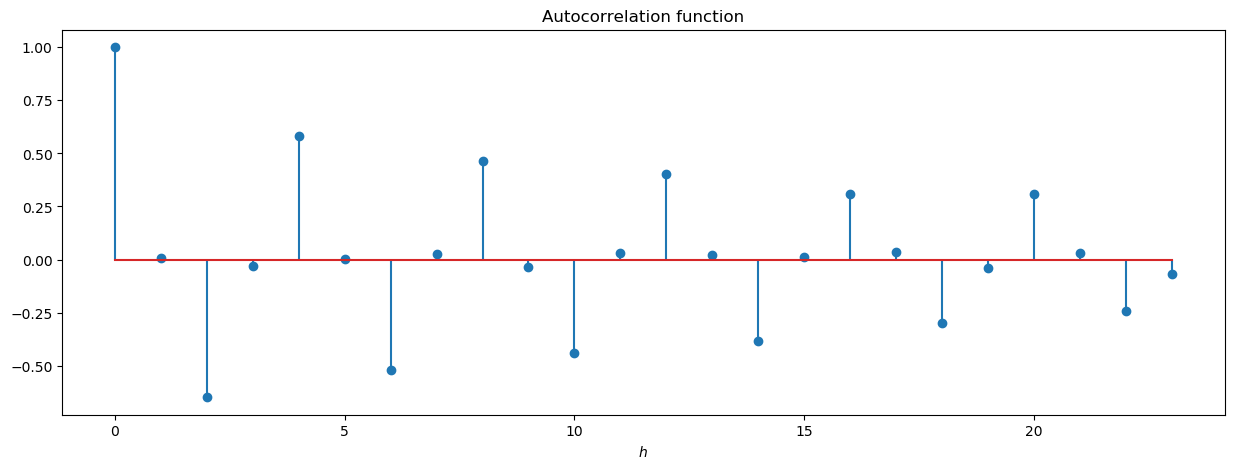

In [32]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:23, autocor(x), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

We see in the autocorrelation function the exponential decresing of the serie (the $\exp\left(-t\right)$ part. Every even $h$, the ACF is equal to $0$ because of the $\cos(2\pi t)$ part.

## Exercise 1.23

Consider the model
$$x_t = 2\cos\left(2\pi \frac{t + 15}{50}\right) + w_t,$$
for $t = 1, \dots, 500$, $\{w_t\}$ is a white noise with $\sigma_w^2 = 1$.

In [36]:
function signal_c(l)
    return [2 * cos(2 * pi * (t + 15) / 50) for t in l]
end

function signal_plus_noise_c(l)
    w = rand(Normal(), length(l))
    return signal_c(l) + w
end

signal_plus_noise_c (generic function with 1 method)

In [53]:
x = signal_plus_noise_c(1:500);

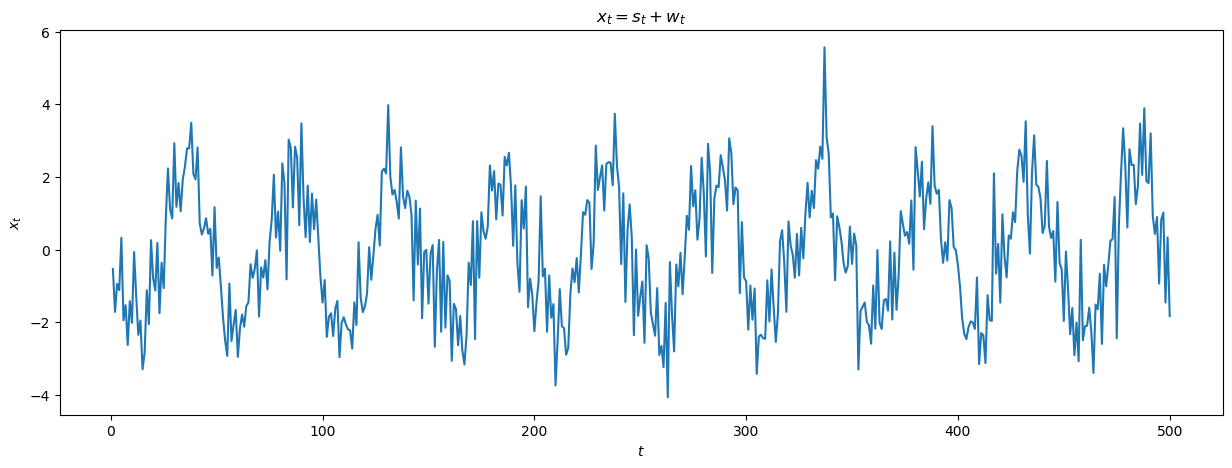

In [54]:
figure(figsize=(15, 5))
plot(1:500, x)
xlabel(L"$t$")
ylabel(L"$x_t$")
title(L"x_t = s_t + w_t")
show()

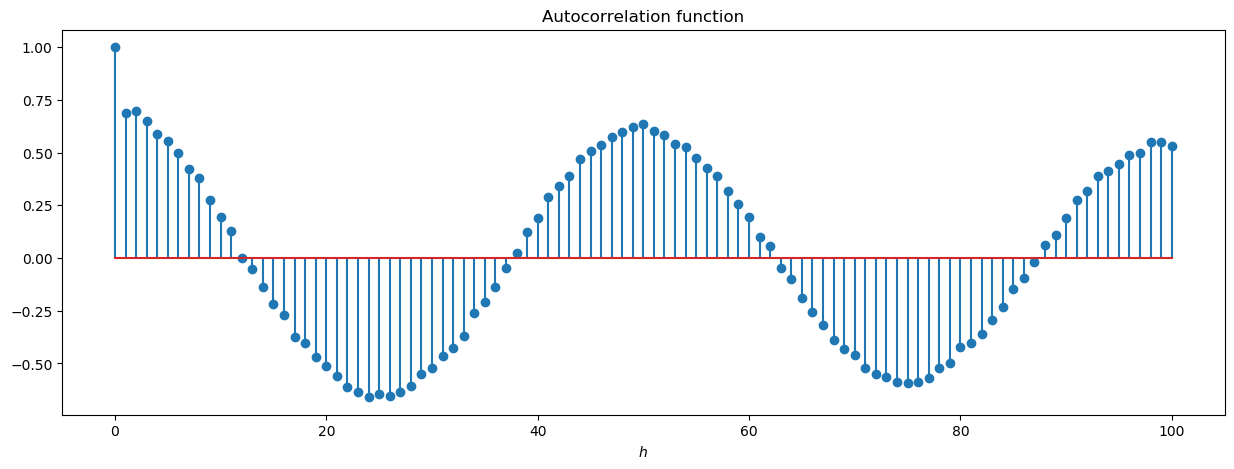

In [55]:
# Plot the ACF
figure(figsize=(15, 5))
stem(0:100, autocor(x, 0:100), use_line_collection=true)
xlabel(L"$h$")
title("Autocorrelation function")
show()

We see the periodic components of the serie in the ACF.

## Exercise 1.24

Let $X$ be a latent variable representing the action of tossing a fair coin. We have that:
$$\mathbb{P}(X = head) = \mathbb{P}(X = tail) = 0.5.$$

Let $x_t$ be a time serie, such that $x_t = 1$ if $X = head$ and $x_t = -1$ if $X = tail$. Then, we construct $y_t$ as
$$y_t = 5 + x_t - 0.7x_{t-1}.$$

The moment of $X$ are:
\begin{align*}
\mathbb{E}(X) &= \mathbb{P}(X = head) \times 1 + \mathbb{P}(X = tail) \times (-1) = 0 \\
Var(X) &= \mathbb{E}(X^2) = \mathbb{P}(X = head) \times 1^2 + \mathbb{P}(X = tail) \times (-1)^2 = 1 \\
\end{align*}

The autocovariance function of $y_t$ is
\begin{align*}
\gamma_y(h) &= Cov(5 + x_{t+h} - 0.7x_{t+h-1}, 5 + x_t - 0.7x_{t-1}) \\
            &= Cov(x_{t+h}, x_t) - 0.7Cov(x_{t+h}, x_{t-1}) - 0.7Cov(x_{t+h-1}, x_t) + 0.7^2Cov(x_{t+h-1}, x_{t-1}) \\
            &= \left\{
                \begin{array}{l l} 
                    1 + 0.7^2 &\text{if} h = 0 \\ 
                    -0.7 &\text{if} h = 1 \\
                    0 &\text{else}
                \end{array}
               \right.
\end{align*}

Finally, we have that 
$$\rho_y(1) = \frac{-0.7}{1 + 0.7^2} \quad\text{and}\quad \rho_y(h) = 0, \quad\text{if}\quad h > 1.$$

## Exercise 1.25

* *Question (a)*

Let show that the autocovariance function $\gamma(h)$ of any stationary time series $x_t$ is non-negative definite function.

Let $a = (a_1, \dots, a_n)^\top \in \mathbb{R}^n$, $t = (t_1, \dots, t_n)^\top \in \mathbb{Z}^n$ and $Z_t = (X_{t_1} - \mathbb{E}(X_{t_1}), \dots, X_{t_n} - \mathbb{E}(X_{t_n}))$.
Then,
\begin{align*}
0 &\leq Var(a^\top Z_t) \\
  &= a^\top \mathbb{E}(Z_tZ_t^\top)a \\
  &= a^\top \Gamma_n a \\
  &= \sum_{i = 1}^n \sum_{j=1}^n a_i \gamma(t_i - t_j) a_j
\end{align*}
where $\Gamma_n$ is the covariance matrix of $(X_{t_1}, \dots, X_{t_n})$.

* *Question (b)*

Assume, without loss of generality, that $\bar{x} = 0$. Let $x_t = 0$ for $t < 1$ or $t > n$ and define the column vector $X_i = (x_{i+1}, \dots, x_{i+n})^\top, -n < i < n$. Then
$$n\Gamma_n = \sum_{i = 1 - n}^{n - 1}X_iX_i^\top,$$
and $a^\top X_iX_i^\top a = (X_i^\top a)^\top(X_i^\top)a \geq 0$ for any column vector $a$.

Thus, $\Gamma_n$ is the sum of nonnegative definite matrices and consequently must also be nonnegative definite. It follows that $\hat{\gamma}(h)$ is nonnegative definite for any $h > 0$.

## Exercise 1.26

Consider a collection of time series $x_{1t}, x_{2t}, \dots, x_{Nt}$ that are observing some common signal $\mu_t$ observed in noise processes $e_{1t}, e_{2t}, \dots, e_{Nt}$, with a model for the $j$th observed series given by
$$x_{jt} = \mu_t + e_{jt}.$$

Suppose the noise series have zero means and are uncorrelated for different $j$. The common autocovariance functions of all series are given by $\gamma_e(s, t)$. Define the sample mean
$$\bar{x}_t = \frac{1}{N}\sum_{j=1}^N x_{jt}.$$

* *Question (a)*

$$\mathbb{E}(\bar{x}_t) = \mathbb{E}\left(\frac{1}{N}\sum_{j=1}^N x_{jt}\right) = \mathbb{E}\left(\frac{1}{N}\sum_{j=1}^N (\mu_t + e_{jt})\right) = \frac{1}{N}\sum_{j=1}^N \mu_t = \mu_t$$

* *Question (b)*

\begin{align*}
\mathbb{E}\left((\bar{x}_t - \mu_t)^2\right) &= \mathbb{E}\left(\left(\frac{1}{N}\sum_{j=1}^N (\mu_t + e_{jt}) - \mu_t\right)^2\right) \\
    &= \mathbb{E}\left(\left(\frac{1}{N}\sum_{j=1}^N e_{jt}\right)^2\right) \\
    &= \frac{1}{N^2}\mathbb{E}\left(\left(\sum_{j=1}^N e_{jt}\right)^2\right) \\
    &= \frac{1}{N}\gamma_e(t, t), \quad\text{because the noise series are uncorrelated}.
\end{align*}

* *Question (c)*

The common signal may be estimated using $\bar{x}_t$, because the square difference between $\bar{x}_t$ and the common signal goes to zero (in mean) as $N$ goes to infinity.

## Exercise 1.27

Let $x_s, s = (s_1, s_2)$ be a spatial process. For $s_1, s_2 = 0, \pm 1, \pm 2, \dots$, defined the variogram
$$V_x(h) = \frac{1}{2}\mathbb{E}((x_{s+h} - x_s)^2)$$
where $h = (h_1, h_2)$, for $h_1, h_2 = 0, \pm 1, \pm 2, \dots$.

We have that 
\begin{align*}
V_x(h) &= \frac{1}{2}\mathbb{E}((x_{s+h} - x_s)^2) \\
       &= \frac{1}{2}\mathbb{E}(((x_{s+h} - \mu) - (x_s - \mu))^2) \\
       &= \frac{1}{2}\mathbb{E}((x_{s+h} - \mu)^2 + (x_s - \mu)^2 - 2(x_{s+h} - \mu)(x_s - \mu)) \\
       &= \frac{1}{2}\left(\mathbb{E}((x_{s+h} - \mu)^2) + \mathbb{E}((x_s - \mu)^2) - 2\mathbb{E}((x_{s+h} - \mu)(x_s - \mu))\right) \\
       &= \gamma(0) - \gamma(h)
\end{align*}

## Exercise 1.28
 
Suppose $x_t = \beta_0 + \beta_1t$, where $\beta_0$ ad $\beta_1$ are constants. We will prove that, as $n \rightarrow \infty$, $\hat{\rho}_x(h) \rightarrow 1$, for fixed $h$.

\begin{align*}
\bar{x} &= \frac{1}{n}\sum_{t = 1}^n (\beta_0 + \beta_1t) = \beta_0 + \beta_1\frac{n(n+1)}{2} \\
\hat{\rho}_x(h) &= \frac{\sum_{t=1}^{n-h}(x_{t+h} - \bar{x})(x_t - \bar{x})}{\sum_{t=1}^{n}(x_{t} - \bar{x})(x_t - \bar{x})} \\
\end{align*}

Then,
\begin{align*}
\sum_{t=1}^{n}(x_{t} - \bar{x})(x_t - \bar{x}) &= \beta_1^2\sum_{t=1}^n\left(t - \frac{n(n+1)}{2}\right)^2 \\
    &= \beta_1^2\sum_{t=1}^n\left(t^2 - 2t\frac{n(n+1)}{4} + \frac{n^2(n+1)^2}{4}\right) \\
    &= \beta_1^2\left(\frac{n(n+1)(2n+1)}{6} - \frac{n^2(n+1)^2}{2} + \frac{n^3(n+1)^2}{4}\right) \\
    &= \frac{\beta_1^2}{12}\left(2n(n+1)(2n+1) - 6n^2(n+1)^2 + 3n^3(n+1)^2\right) \\
    &= \mathcal{O}(n^5)
\end{align*}

\begin{align*}
\sum_{t=1}^{n-h}(x_{t+h} - \bar{x})(x_t - \bar{x}) &= \beta_1^2\sum_{t=1}^n\left(t + h - \frac{n(n+1)}{2}\right)\left(t - \frac{n(n+1)}{2}\right) \\
    &= \beta_1^2\sum_{t=1}^n\left(t^2 - tn(n+1) + \frac{n^2(n+1)^2}{4} + ht - h\frac{n(n+1)}{2}\right) \\
    &= \beta_1^2\left(\frac{n(n+1)(2n+1)}{6} - \frac{n^2(n+1)^2}{2} + \frac{n^3(n+1)^2}{4} + h\frac{n(n+1)}{4} - h\frac{n^2(n+1)^2}{4}\right) \\
    &= \frac{\beta_1^2}{12}\left(2n(n+1)(2n+1) - 6n^2(n+1)^2 + 3n^3(n+1)^2 + 6hn(n+1)(1-n)\right) \\
    &= \mathcal{O}(n^5)
\end{align*}

Finally, $\hat{\rho}_x(h) = \mathcal{O}(1)$, as $n \rightarrow \infty$.

## Exercise 1.29

* *Question (a)*

Suppose $x_t$ is a weakly stationary time series with mean zero and with absolutely summable autocovariance function, $\gamma(h)$, such that
$$\sum_{h=-\infty}^{\infty} \gamma(h) = 0$$

The variance of the sample mean $\bar{x}$ is (see *e.g.* J. Hamilton,Time Series Analysis, 1994, p.187-188),
$$Var(\bar{x}) = \frac{1}{n^2}\sum_{h = -n}^n (n - \lvert h \rvert)\gamma(h) = \frac{1}{n}\sum_{h = -n}^n \frac{n - \lvert h \rvert}{n}\gamma(h).$$

And then, 
$$nVar(\bar{x}) = \sum_{h = -n}^n \frac{n - \lvert h \rvert}{n}\gamma(h) \underset{n \rightarrow \infty}{\longrightarrow}  \sum_{h = -\infty}^\infty \gamma(h) = 0,$$
by dominated convergence, because $\lvert (1 - \lvert h\rvert / n)\gamma(h)\rvert \leq \lvert\gamma(h)\rvert$ and $(1 - \lvert h\rvert / n)\gamma(h) \rightarrow \gamma(h)$.

Finally, $\sqrt{n}\bar{x} \overset{ms}{\rightarrow} 0$, which implies $\sqrt{n}\bar{x} \overset{p}{\rightarrow} 0$.

* *Question (b)*

I think that the only process that satisfies the previous assumption in a constant process with mean $0$, because, in order to have $\sum_{h = -\infty}^\infty \gamma(h) = 0$, the variance of the process should be $0$ and only deterministic processes have null variance. Moreover, it should have zero mean. And, for a deterministic process, only constant ones have mean that does not depend on time.

## Exercise 1.30

Let $x_t$ be a linear process of the form
$$x_t = \mu_x + \sum_{j = -\infty}^{\infty} \psi_j w_{t-j}$$
where $w_t$ is a white noise process with variance $\sigma^2$, and $\sum \lvert \psi_j \rvert < \infty$.

Define

\begin{align*}
\hat \gamma \left( h \right) &= \frac{1}{n}\sum_{t = 1}^{n - h} {\left( x_t - \bar x \right)\left( x_{t + h} - \bar x \right)}\\
\tilde{\gamma} \left( h \right) &= \frac{1}{n}\sum_{t = 1}^{n} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right)}
\end{align*}

We want to show that
$$n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right) = \mathcal{o}_p(1) \Leftrightarrow \mathbb{P}\left(\left\lvert n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right)\right\rvert > \epsilon \right) \longrightarrow 0, \forall \epsilon > 0.$$

Using the Markov inequality, we have that:
$$\forall \epsilon > 0, \mathbb{P}\left(\left\lvert n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right)\right\rvert > \epsilon\right) \leq \frac{1}{\epsilon}\mathbb{E}\left(\left\lvert n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right)\right\rvert\right)$$

Then,
\begin{align*}
n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right) &= n^{\frac{1}{2}}\left(\frac{1}{n}\sum_{t = 1}^{n} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right)} - \frac{1}{n}\sum_{t = 1}^{n - h} {\left( x_t - \bar x \right)\left( x_{t + h} - \bar x \right)}\right) \\
    &= \frac{1}{n^{\frac{1}{2}}}\left(\sum_{t = n-h+1}^{n} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right)} + \sum_{t = 1}^{n - h} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right) - \left( x_t - \bar x \right)\left( x_{t + h} - \bar x \right)}\right)
\end{align*}

Considering only the second term,
\begin{align*}
\sum_{t = 1}^{n - h} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right) - \left( x_t - \bar x \right)\left( x_{t + h} - \bar x \right)} &= \sum_{t = 1}^{n - h} \left({x_t  (\bar x - \mu_x) + x_{t + h} (\bar x - \mu_x)  - \left( \bar x - \mu_x\right)\left( \bar x + \mu_x\right)}\right)\\
    &= \left(\bar x - \mu_x\right)\sum_{t = 1}^{n - h} \left({x_t + x_{t + h} - \bar x - \mu_x}\right) \\
    &= \left(\bar x - \mu_x\right)\left(\sum_{t = 1}^{n - h} x_t + \sum_{t = 1+h}^{n} x_{t} - (n-h)\bar x - (n-h)\mu_x\right) \\
    &= \left(\bar x - \mu_x\right)\left(\sum_{t = 1+h}^{n - h} x_t + \sum_{t = 1}^{n} x_{t} - (n-h)\bar x - (n-h)\mu_x\right) \\
    &= \left(\bar x - \mu_x\right)\left(\sum_{t = 1+h}^{n - h} x_t + h\bar x - (n-h)\mu_x\right) \\
    &= \left(\bar x - \mu_x\right)\left(\sum_{t = 1+h}^{n - h} (x_t - \mu_x) + h(\bar x - \mu_x)\right) \\
    &= \left(\bar x - \mu_x\right)\sum_{t = 1+h}^{n - h} (x_t - \mu_x) + h(\bar x - \mu_x)^2 \\
\end{align*}

Returning to the previous equation, we have that
$$n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right) = \frac{1}{n^{\frac{1}{2}}}\sum_{t = n-h+1}^{n} {\left( x_t - \mu_x \right)\left( x_{t + h} - \mu_x \right)} + \frac{1}{n^{\frac{1}{2}}}\left(\bar x - \mu_x\right)\sum_{t = 1+h}^{n - h} (x_t - \mu_x) + \frac{h}{n^{\frac{1}{2}}}(\bar x - \mu_x)^2 $$

We continue using the triangle inequality:
$$\mathbb{E}\left(\left\lvert n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right)\right\rvert\right) \leq \frac{1}{n^{\frac{1}{2}}}\sum_{t = n-h+1}^{n} \mathbb{E}{\left\lvert( x_t - \mu_x )( x_{t + h} - \mu_x )\right\rvert} + \frac{1}{n^{\frac{1}{2}}}\mathbb{E}\left[\left\lvert\left(\bar x - \mu_x\right)\sum_{t = 1+h}^{n - h} (x_t - \mu_x)\right\rvert\right] + \frac{h}{n^{\frac{1}{2}}}\mathbb{E}(\bar x - \mu_x)^2.$$

For the first term, using Cauchy-Schwarz inequality, we have:
$$\mathbb{E}{\left\lvert( x_t - \mu_x )( x_{t + h} - \mu_x )\right\rvert} \leq \mathbb{E}\left(\left\lvert( x_t - \mu_x )\right\rvert^2\right)^{1/2} \mathbb{E}\left(\left\lvert( x_{t + h} - \mu_x )\right\rvert^2\right)^{1/2} = \sigma^2\sum_{j=-\infty}^{\infty} \psi_j^2 \leq \sigma^2\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)^2< \infty$$

For the last term, using equation (A.46)-(A-47), we have:
$$\mathbb{E}(\bar x - \mu_x)^2 = \frac{\sigma^2}{n}\left(\sum_{j=-\infty}^{\infty} \psi_j\right)^2 \leq \frac{\sigma^2}{n}\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)^2 < \infty$$

Finally, for the middle term, again using Cauchy-Schwarz inequality, we have:
\begin{align*}
\mathbb{E}\left[\left\lvert\left(\bar x - \mu_x\right)\sum_{t = 1+h}^{n - h} (x_t - \mu_x)\right\rvert\right] &\leq \mathbb{E}\left[\left\lvert\left(\bar x - \mu_x\right)\right\rvert^2\right]^{1/2}\mathbb{E}\left[\left\lvert\sum_{t = 1+h}^{n - h} (x_t - \mu_x)\right\rvert^2\right]^{1/2} \\
&\leq \frac{\sigma}{\sqrt{n}}\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)\left[\sum_{t = 1+h}^{n - h} \mathbb{E}(x_t - \mu_x)^2\right]^{1/2} \\
&\leq \frac{\sigma}{\sqrt{n}}\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)\left[\sum_{t = 1+h}^{n - h} Var(x_t)\right]^{1/2} \\
&\leq \frac{\sigma}{\sqrt{n}}\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)(n-2h)^{1/2}\sigma\left(\sum_{j=-\infty}^{\infty} \psi_j^2\right)^{1/2} \\
&\leq \sqrt{\frac{n-2h}{n}}\sigma^2\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)^2 < \infty
\end{align*}

To conclude the proof, we write
$$\mathbb{E}\left(\left\lvert n^{\frac{1}{2}}\left(\tilde{\gamma} \left( h \right) - \hat \gamma \left( h \right)\right)\right\rvert\right) \leq \frac{nh + \sqrt{n(n - 2h)} + h}{n\sqrt{n}}\sigma^2\left(\sum_{j=-\infty}^{\infty} \lvert\psi_j\rvert\right)^2 \longrightarrow 0.$$

## Exercise 1.31

Let $x_t$ be a linear process of the form
$$x_t = \sum_{j=0}^\infty \phi^j w_{t-j}$$
where $\{w_t\}$ as finite fourth moment and $\lvert \phi \rvert < 1$. In particular, $x_t$ is a process of the form
$$x_t = \sum_{j=0}^\infty \psi_j w_{t-j} \quad\text{where}\quad \psi_j = \left\{\begin{array}{r l} \phi^j, &\quad j \geq 0 \\ 0, &\quad j < 0  \end{array}\right.$$
Moreover, $x_t$ may be written under an AR(1) form
$$x_t = \phi X_{t-1} + w_t.$$

The autocovariance function of an AR(1) process is given by
$$\gamma(h) = \sigma^2\sum_{j=0}^\infty \phi^j \phi^{j+h} = \sigma^2 \phi^h\sum_{j=0}^\infty \phi^{2j} = \frac{\sigma^2\phi^h}{1 - \phi^2}.$$
And then, the variance of an AR(1) process is
$$\gamma(0) = \frac{\sigma^2}{1 - \phi^2},$$
and its autocorrelation function is
$$\rho(h) = \frac{\gamma(h)}{\gamma(0)} = \phi^h.$$

As, $x_t$ satifies the assumptions of the theorem A.7, we have the following result:
$$\widehat{\rho}(1) \sim A\mathcal{N}(\rho(1), n^{-1}W),$$
where $W = \sum_{u=1}^\infty \left(\rho(u+1) + \rho(u-1) - 2\rho(1)\rho(u)\right)^2.$

Let's compute $W$:
\begin{align*}
W &= \sum_{u=1}^\infty \left(\rho(u+1) + \rho(u-1) - 2\rho(1)\rho(u)\right)^2 \\
    &= \sum_{u=1}^\infty \left(\phi^{u+1} + \phi^{u-1} - 2\phi^1\phi^u\right)^2 \\
    &= \sum_{u=1}^\infty \left(\phi^{u-1} - \phi^{u+1}\right)^2 \\
    &= \sum_{u=1}^\infty \left(\phi^{2(u-1)} + \phi^{2(u+1)} - 2\phi^{(u+1) + (u+1)}\right)^2 \\
    &= \sum_{u=1}^\infty \left(\phi^{2u}\left(\phi^2 + \phi^{-2} - 2\right)\right) \\
    &= \left(\phi^2 + \phi^{-2} - 2\right)\left(\sum_{u=0}^\infty \phi^{2u} - 1\right) \\
    &= \left(\phi^2 + \phi^{-2} - 2\right)\left(\frac{1}{1 - \phi^2} - 1\right) \\
    &= \frac{\phi^4 - 2\phi^2 + 1}{1 - \phi^2} \\
    &= 1 - \phi^2 \\
    &= 1 - \rho(1)^2
\end{align*}

Finally, we have the following convergence in distribution:
$$\sqrt{n}\frac{\widehat{\rho}(1) - \rho(1)}{\sqrt{1 - \rho(1)^2}} \xrightarrow{d} \mathcal{N}(0, 1).$$

A confidence for $\rho(1)$ (and so for $\phi$ is given by
$$\left[\widehat{\rho}(1) - \mathcal{t}_{0.975, n-1}\sqrt{\frac{1 - \widehat{\rho}^2(1)}{n}}; \widehat{\rho}(1) + \mathcal{t}_{0.975, n-1}\sqrt{\frac{1 - \widehat{\rho}^2(1)}{n}}\right] = [0.49; 0.79],$$
where $\mathcal{t}_{0.975, n-1}$ is the quantile of the student distribution at confidence level $97.5\%$ and $n-1$ degree of freedom. We use the student distribution, because we had to estimate the standard deviation of $\rho(1)$.

## Exercise 1.32

Let $\{x_t, t = 0, \pm 1, \pm 2, \dots\}$ be iid$(0, \sigma^2)$.

* *Question (a)*

Let $h \geq 1$, $k \geq 1$ and $s \neq t$, then
$$
Cov(x_tx_{t+h}, x_sx_{s+k}) = \mathbb{E}(x_tx_{t+h}x_sx_{s+k}) + \mathbb{E}(x_tx_{t+h})\mathbb{E}(x_sx_{s+k}) = 0,
$$

* *Question (b)*

Let $c = (c_1, \dots, c_h)^\top \in \mathbb{R}^h$, and $X_n = (\sum x_tx_{t+1}, \dots, \sum x_tx_{t+h})^\top$. We aim to compute the moments of $c^\top X_n$

\begin{align*}
\mathbb{E}(c^\top X_n) &= \sum_{i = 1}^h c_i \sum_{t=1}^n \mathbb{E}(x_t x_{t+i}) = 0 \\
Var(c^\top X_n) &= \sum_{i = 1}^h c_i^2 \sum_{t=1}^n Var(x_t x_{t+i}) = n\sigma^4 \sum_{i=1}^h c_i^2
\end{align*}
because, we have for two random variables $X$ and $Y$:
$$Var(XY) = \mathbb{E}(X^{2}Y^{2}) - \mathbb{E}(XY)^{2} = Cov(X^{2}, Y^{2}) + [Var(X) + \mathbb{E}(X)^2] \times [Var(Y) + \mathbb{E}(Y)^2] - [ Cov(X,Y) + \mathbb{E}(X)\mathbb{E}(Y) ]^{2}$$

So, we have the following result:
$$\sigma^{-2}n^{-1/2}c^\top X_n \xrightarrow{d} c^\top z, \quad\text{where}\quad z = (z_1, \dots, z_h)^\top$$
with $z_1, \dots, z_h$ are iid $\mathcal{N}(0, 1)$ random variables.

Finally, using the Cramér-Wold device, 
$$\sigma^{-2}n^{-1/2} X_n \xrightarrow{d} z$$

* *Question (c)*

We would like to show that, for each $h \geq 1$,
$$n^{-1/2}\left(\sum_{t=1}^{n} x_tx_{t+h} - \sum_{t=1}^{n-h}(x_t - \bar x)(x_{t+h} - \bar x)\right) \xrightarrow{p} 0, \quad\text{as}~ n \rightarrow \infty$$

This is equivalent to show that 
$$\mathbb{P}\left(\left\lvert n^{-1/2}\left(\sum_{t=1}^{n} x_tx_{t+h} - \sum_{t=1}^{n-h}(x_t - \bar x)(x_{t+h} - \bar x)\right)\right\rvert > \epsilon\right) \xrightarrow[n \rightarrow \infty]{} 0, \forall \epsilon > 0.$$

Then, using the Markov inequality,
\begin{align*}
\mathbb{P}\left(\left\lvert n^{-1/2}\left(\sum_{t=1}^{n} x_tx_{t+h} - \sum_{t=1}^{n-h}(x_t - \bar x)(x_{t+h} - \bar x)\right)\right\rvert > \epsilon\right) &\leq \frac{1}{\epsilon}\mathbb{E}\left(\left\lvert n^{-1/2}\left(\sum_{t=1}^{n} x_tx_{t+h} - \sum_{t=1}^{n-h}(x_t - \bar x)(x_{t+h} - \bar x)\right)\right\rvert\right) \\
    &\leq \frac{1}{\epsilon\sqrt{n}}\mathbb{E}\left(\left\lvert \left(\sum_{t=n-h+1}^{n} x_tx_{t+h} + \bar x \sum_{t=1}^{n-h}(x_t + x_{t+h}) - (n-h)\bar x^2\right)\right\rvert\right) \\
    &\leq \frac{1}{\epsilon\sqrt{n}}
    \mathbb{E}\left(\left\lvert\sum_{t=n-h+1}^{n} x_tx_{t+h}\right\rvert\right) + 
    \mathbb{E}\left(\left\lvert\bar x \sum_{t=1}^{n-h}(x_t + x_{t+h})\right\rvert\right) + 
    (n-h)\mathbb{E}\left(\bar x^2\right) \\
\end{align*}

First term:
$$
\mathbb{E}\left(\left\lvert\sum_{t=n-h+1}^{n} x_tx_{t+h}\right\rvert\right) \leq \sum_{t=n-h+1}^{n}\mathbb{E}\left\lvert x_tx_{t+h}\right\rvert \leq \sum_{t=n-h+1}^{n}\mathbb{E}(x_t^2)^{1/2}\mathbb{E}(x_{t+h}^2)^{1/2} \leq h\sigma^2$$

Last term:
$$\mathbb{E}\left(\bar x^2\right) = Var(\bar x^2) = \frac{1}{n^2}\sum_{t=1}^n Var(x_t) = \frac{\sigma^2}{n} $$

Middle term:
$$\mathbb{E}\left(\left\lvert\bar x \sum_{t=1}^{n-h}(x_t + x_{t+h})\right\rvert\right) \leq 2\mathbb{E}\left(\left\lvert\bar x \sum_{t=1}^{n-h} x_t\right\rvert\right) \leq \mathbb{E}(\bar x^2)^{1/2}\mathbb{E}\left(\left\lvert\sum_{t=1}^{n-h} x_t\right\rvert^2\right)^{1/2} \leq \frac{2\sigma}{\sqrt{n}}\left(\sum_{t=1}^{n-h} \mathbb{E}(x_t^2)\right)^{1/2} \leq 2\sqrt{\frac{n - h}{n}}\sigma^2$$

And finally, 
$$\mathbb{P}\left(\left\lvert n^{-1/2}\left(\sum_{t=1}^{n} x_tx_{t+h} - \sum_{t=1}^{n-h}(x_t - \bar x)(x_{t+h} - \bar x)\right)\right\rvert > \epsilon\right) \leq \frac{\sigma^2}{\epsilon}\frac{nh + 2\sqrt{n(n-h} + 1}{n\sqrt{n}} \xrightarrow[n \rightarrow \infty]{} 0.$$

* *Question (d)*

Noting that $n^{-1}\sum_{t=1}^n x_t^2 \xrightarrow{p} \sigma^2$, and let $\widehat\rho = (\widehat\rho(1), \dots, \widehat\rho(h))^\top$. We conclude that
$$n^{1/2}\widehat\rho \xrightarrow{p} \sigma^{-2}n^{-1/2}X_n \xrightarrow{d} z \Longleftrightarrow n^{1/2}\widehat\rho \xrightarrow{d} z.$$